In [1]:
%load_ext autoreload
%autoreload 2

# Generate MURA -- Modified Uniformly Redundant Arrays

The purpose of this notebook is to generate MURAs as defined by Gottesman and Fenimore (1989) in “New family of binary arrays for coded aperture imaging”. These MURAs will be used in the pre-processing step of the MNIST data to make encode the training data and make he images irrecognizable. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import correlate2d
from scipy.signal import convolve2d
from scipy.fft import fft2, ifft2

from torchvision import datasets
import torchvision.transforms as transforms

# Define functions

In [6]:
def FFT_convolve(A, B, p=None):
    '''
    Compute convolution using FFT between A and B
    Inputs: 
        A,B: np.ndarrays
        
    Outputs:
        conv_AB: nd.array. Convolution between A and B
    '''
    # Check A and B are the same size
    if np.array(A).shape != np.array(B).shape:
        raise Exception("The arrays A and B are not the same shape")
    
    # Define p if it is not given already
    if p is None:
        p = A.shape[0]
        
    # Do convolution via FFT   
    fft_A = fft2(A)
    fft_B = fft2(B)
    conv_AB = np.real(ifft2(np.multiply(fft_A,fft_B)))
    conv_AB = np.roll(conv_AB, [int((p-1)/2),int((p-1)/2)], axis=(0,1))
    
    return conv_AB

In [7]:
# normalize 

def normalize(data):
    normalized_data = (data-np.min(data))/(np.max(data)-np.min(data))
    return normalized_data

In [8]:
def add_Gaussian_noise(image, mean=0, var=0.1):
    """
    Inputs:
        image: np.array of size [height, width]. Image to which Gaussian filter will be added
        mean:  Mean for Gaussian distribution
        var:   Variance for Gaussian distribution
        
    Outputs:
        noisy: Image with added Gaussian noise
    """
    
    row,col = image.shape
    
    # Calculate Gaussian filter
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    
    # Add Gaussian filter to image
    noisy = image + gauss
    return noisy


def get_Gaussian_filter(image, mean=0, var=0.1):
    """
    Inputs:
        image: np.array of size [height, width]. Provides dimensions for filter
        mean:  Mean for Gaussian distribution
        var:   Variance for Gaussian distribution
        
    Outputs:
        noisy: Gaussian filter
    """
    
    row,col = image.shape
    
    # Calculate Gaussian filter
    sigma = var**0.5
    gauss = np.random.normal(mean,sigma,(row,col))
    gauss = gauss.reshape(row,col)
    
    return gauss 

In [9]:
def create_binary_aperture_arr(p):
    '''
    Inputs
        p: int. prime integer
        
    Output
        A: np.array. Binary aperture array 
    '''
    A = np.zeros((p,p)) # binary aperture array
    # Aperture function p. 4350 in Gottesman and Fenimore (1989)
    for i in range(0,p):
        for j in range(0,p):
            C_i = legendre_symbol(i,p)
            C_j = legendre_symbol(j,p)

            if i == 0:
                A[i,j] = 0
            elif (j == 0 and i != 0):
                A[i,j] = 1
            elif (C_i * C_j) == 1:
                A[i,j] = 1
            else:
                A[i,j] = 0
    return A
                
# copied from https://eli.thegreenplace.net/2009/03/07/computing-modular-square-roots-in-python on 10/05/22
def legendre_symbol(a, p):
    """ Compute the Legendre symbol a|p using
        Euler's criterion. p is a prime, a is
        relatively prime to p (if p divides
        a, then a|p = 0)

        Returns 1 if a has a square root modulo
        p, -1 otherwise.
    """
    ls = pow(a, (p - 1) // 2, p)
    return -1 if ls == p - 1 else ls

In [10]:
def create_decoding_arr(A):
    '''
    Inputs
        A: np.array. Binary aperture array
        
    Output
        G: np.array of same size as A. Decoding function 
    '''
    
    G = np.zeros_like(A) # initialize decoding function
    p = G.shape[0]
    
    # Decoding function p. 4350 in Gottesman and Fenimore (1989)
    for i in range(0,p):
        for j in range(0,p):

            if (i + j) == 0:
                G[i,j] = 1
            elif (A[i,j] == 1 and (i + j) != 0):
                G[i,j] = 1
            elif (A[i,j] == 0 and (i + j) != 0):
                G[i,j] = -1
                
                
    return G

# Encoder and decoder from the paper

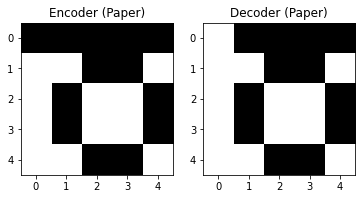

In [11]:
# A is the 5x5 MURA aperture
# from the Gottesman and Fenimore paper
A = [[0,0,0,0,0], 
     [1,1,0,0,1], 
     [1,0,1,1,0], 
     [1,0,1,1,0],
     [1,1,0,0,1]]
G = [[1,-1,-1,-1,-1], 
     [1,1,-1,-1,1], 
     [1,-1,1,1,-1], 
     [1,-1,1,1,-1],
     [1,1,-1,-1,1]]

fig, axs = plt.subplots(1,2)
axs = axs.ravel()
axs[0].imshow(A, cmap='gray')
axs[1].imshow(G, cmap='gray')
axs[0].set_title("Encoder (Paper)")
axs[1].set_title("Decoder (Paper)")
plt.show()

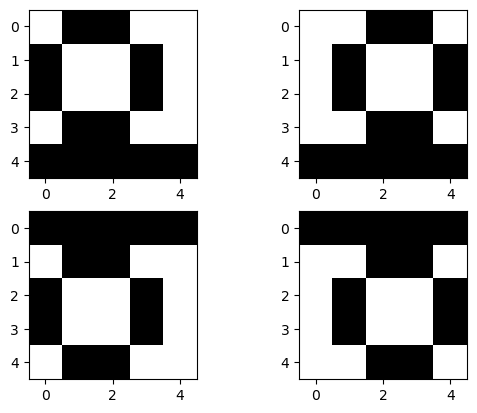

In [5]:
# Testing how to do reflections for mosaic
# A[::-1] is all items in the array, reversed
fig, axs = plt.subplots(2,2)
axs = axs.ravel()
axs[0].imshow(np.fliplr(A[::-1]), cmap='gray')
axs[1].imshow(A[::-1], cmap='gray')
axs[2].imshow(np.fliplr(A), cmap='gray')
axs[3].imshow(A, cmap='gray')

# Make MURA

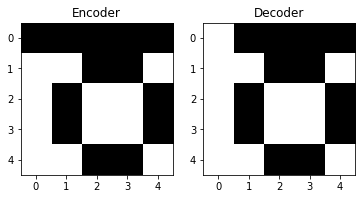

In [12]:
# Test with p=5 to check with paper 
p = 5 # size of array
A = create_binary_aperture_arr(p)
G = create_decoding_arr(A)

fig, axs = plt.subplots(1,2)
axs = axs.ravel()
axs[0].imshow(A, cmap='gray')
axs[1].imshow(G, cmap='gray')
axs[0].set_title("Encoder")
axs[1].set_title("Decoder")
plt.show()

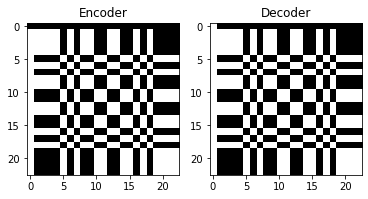

In [14]:
p = 23 # size of array
# First, create A and G
A = create_binary_aperture_arr(p)
G = create_decoding_arr(A)

# Note: This mosaic technique didn't work (i.e. when we convolve encoder * decoder, we don't get \delta)
# # Make mosaic by stacking matrix horizontally and then vertically
# h_stack = np.concatenate((A,A), axis=1)
# v_stack = np.concatenate((h_stack, h_stack), axis=0)
# cut out top and left edges (not needed)
# encoder = v_stack[1:,1:]
# decoder = create_decoding_arr(encoder)



#plt.imshow(A, cmap='gray');plt.show()
fig, axs = plt.subplots(1,2)
axs = axs.ravel()
axs[0].imshow(A, cmap='gray')
axs[1].imshow(G, cmap='gray')
axs[0].set_title("Encoder")
axs[1].set_title("Decoder")
plt.show()

# Load MNIST to test encoding

In [15]:
# Load training and testing data from PyTorch
size = A.shape[0]
train_data = datasets.MNIST(
    root = '../data/',
    train = True,                         
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(size),
                    transforms.Normalize(mean=0., std=(1/255.))
                    #transforms.Normalize(0, 1)
                ]), 
    download = False,            
)
test_data = datasets.MNIST(
    root = '../data/', 
    train = False, 
    transform = transforms.Compose([
                    transforms.ToTensor(),
                    transforms.Resize(size),
                    transforms.Normalize(mean=0., std=(1/255.))
                    #transforms.Normalize(0, 1)
                ]) 
)

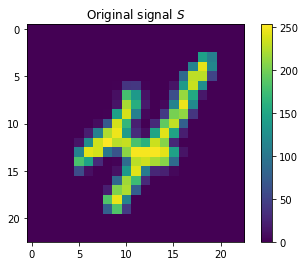

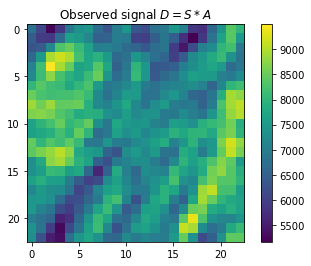

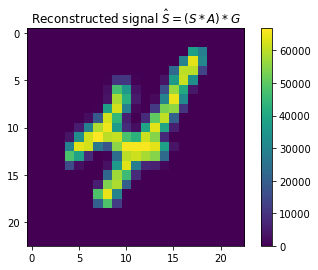

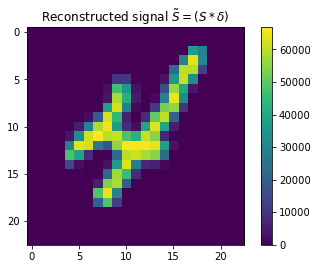

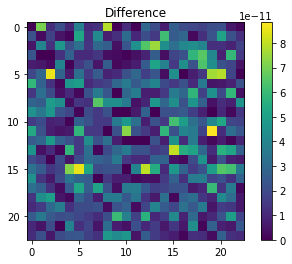

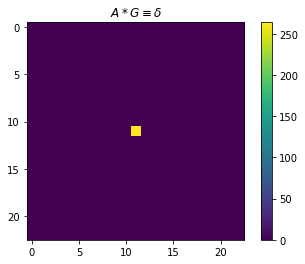

264.0


In [17]:
# S = original data
# B = background noise (Gaussian in this case)
# kroneker_delta = (A * G)
# D = S * A + B Observed data 
# S_hat = (S*A)*G + B*G = S + B*G Reconstructed data
# N = sum_ij A_ij

S = train_data[9][0][0].numpy().astype('int64') 
B = get_Gaussian_filter(S, mean=0, var=0.1) 
kroneker_delta = FFT_convolve(A,G,p)
D = FFT_convolve(S,A,p) #+ B
S_hat = FFT_convolve(D,G,p) 
S_tilde = FFT_convolve(S, kroneker_delta,p)
N = np.sum(A)
diff_Shat_Stilde = np.abs(S_hat - S_tilde)
S_normed = normalize(S)

cmap = 'viridis'

# fig, axs = plt.subplots(2,2, figsize=(15,10))
# axs = axs.ravel()
# axs[0].imshow(S, cmap=cmap)
# axs[1].imshow(D, cmap=cmap)
# axs[2].imshow(S_hat, cmap=cmap)
# axs[3].imshow(S_tilde, cmap=cmap)

# axs[0].set_title("Original signal $S$")
# axs[1].set_title("Observed signal $D = S * A$")
# axs[2].set_title("Reconstructed signal $\hat{S} = (S*A)*G$")
# axs[3].set_title("Reconstructed signal $\~{S} = (S*\delta)$")
# plt.show()

plt.imshow(S, cmap=cmap); plt.colorbar()
plt.title("Original signal $S$")
plt.show()

plt.imshow(D, cmap=cmap); plt.colorbar()
plt.title("Observed signal $D = S * A$")
plt.show()

plt.imshow(S_hat, cmap=cmap); plt.colorbar()
plt.title("Reconstructed signal $\hat{S} = (S*A)*G$")
plt.show()

plt.imshow(S_tilde, cmap=cmap); plt.colorbar()
plt.title("Reconstructed signal $\~{S} = (S*\delta)$")
plt.show()

plt.imshow(diff_Shat_Stilde); plt.colorbar()
plt.title("Difference")
plt.show()
plt.imshow(kroneker_delta); plt.colorbar();
plt.title("$A*G \equiv \delta$")
plt.show()
print(np.max(kroneker_delta))

In [23]:
# should be peak of kronecker delta
p**2/2

264.5